In [60]:
import pandas as pd
import re
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# df_arr = []
# logs = ['c_exploits/20210507_exploit_explore.log', 'c_exploits/20210607_exploit_explore.log', 'c_exploits/20210713_exploit_explore.log', 'c_exploits/20210825.csv']
# for log in logs:
#     print(log)
#     df = pd.read_csv(log, delimiter=":", names=['a', 'b'])
#     df[['exploit','explore']] = df['b'].str.split(',',expand=True)
#     df.reset_index(inplace=True, drop=True)
#     df = df.drop(['a', 'b'], axis=1)
#     df['exploit'] = df['exploit'].astype('float')
#     df_arr.append(df)
# df_arr = pd.concat(df_arr)

c_exploits/20210507_exploit_explore.log
c_exploits/20210607_exploit_explore.log
c_exploits/20210713_exploit_explore.log
c_exploits/20210825.csv


In [4]:
# df_arr.exploit.mean()

8074255.058280257

# IT SEARCH

In [73]:
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"
dates = ['20211018', '20211123', '20211215', '20220127', '20220225']
df_arr = []
for date in dates:
    ITS = [0, 50, 100, 200, 400]
    for IT in ITS:
        if IT > 0:
            fp = f"IT_SEARCH/no_inject_{date}_mcts_{IT}IT.log"
        else:
            fp = f"IT_SEARCH/no_inject_{date}_BL.log"
        # bus stats
        bus_stats = []

        with open(fp) as file:
            for line in file:
                if 'on trip:' in line:
                    data = line.rstrip()
                    in_brackets = re.findall("\[(.*?)\]", data)
                    out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
                    log_text = out_brackets[2].strip()
                    
                    time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
                    bus = log_text.split(" ")[1]
                    trip = log_text.split(" ")[4]
                    scheduled_time = log_text.split(" ")[7] + " " + log_text.split(" ")[8]
                    scheduled_time = dt.datetime.strptime(scheduled_time, DATETIME_FORMAT)
                    stop_id = log_text.split(" ")[12][:-1]
                    got_on = log_text.split(" ")[13].split(":")[1][:-1]
                    on = log_text.split(" ")[14].split(":")[1][:-1]
                    offs = log_text.split(" ")[15].split(":")[1][:-1]
                    remain = log_text.split(" ")[16].split(":")[1][:-1]
                    load = log_text.split(" ")[17].split(":")[1]
                    
                    entry = {"actual_time":time,
                            "bus_id":bus,
                            "trip_id":trip,
                            "scheduled_time":scheduled_time,
                            "stop_id":stop_id,
                            "got_on_bus":got_on,
                            "waiting_to_board":on,
                            "offs":offs,
                            "left":remain,
                            "load":load}
                    bus_stats.append(entry)
        bus_stats = pd.DataFrame(bus_stats)
        bus_stats['got_on_bus'] = bus_stats['got_on_bus'].astype('int')
        bus_stats['waiting_to_board'] = bus_stats['waiting_to_board'].astype('int')
        bus_stats['offs'] = bus_stats['offs'].astype('int')
        bus_stats['left'] = bus_stats['left'].astype('int')
        bus_stats['load'] = bus_stats['load'].astype('int')
        bus_stats['IT'] = IT
        # print(date, IT, bus_stats.got_on_bus.sum())
        df_arr.append(bus_stats)
df = pd.concat(df_arr)
df['date'] = df['actual_time'].dt.date

In [74]:
df

,actual_time,bus_id,trip_id,scheduled_time,stop_id,got_on_bus,waiting_to_board,offs,left,load,IT,date
0,2021-10-18 08:05:00,2013,262669,2021-10-18 08:05:00,MCC4_19,4,4,0,0,4,0,2021-10-18
1,2021-10-18 08:06:33,2013,262669,2021-10-18 08:06:33,4AVCHUSN,0,0,2,0,2,0,2021-10-18
2,2021-10-18 08:08:20,2013,262669,2021-10-18 08:08:20,MXOMCCTR,2,2,0,0,4,0,2021-10-18
3,2021-10-18 08:09:34,2013,262669,2021-10-18 08:09:34,NXOPBODY,0,0,1,0,3,0,2021-10-18
4,2021-10-18 08:10:38,2013,262669,2021-10-18 08:10:38,MXOFULTN,0,0,2,0,1,0,2021-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2022-02-25 12:25:45,42,263580,2022-02-25 10:12:00,GXORIVEN,0,0,0,0,0,400,2022-02-25
1630,2022-02-25 12:26:07,42,263580,2022-02-25 10:12:58,GALCONNN,0,0,0,0,0,400,2022-02-25
1631,2022-02-25 12:26:39,42,263580,2022-02-25 10:16:00,GALWMRT,0,0,0,0,0,400,2022-02-25
1632,2022-02-25 12:27:17,42,263580,2022-02-25 10:19:34,GALCONSF,0,0,0,0,0,400,2022-02-25


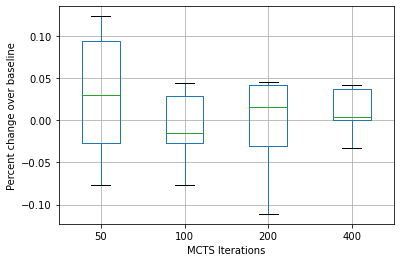

In [159]:
# df.groupby(['date', 'IT']).sum().groupby('IT').boxplot(rot=45, fontsize=12, figsize=(8,10))
tdf = df.groupby(['IT','date']).sum()[['got_on_bus']].reset_index().pivot(index='date', columns='IT', values='got_on_bus')
tdf['50s']  = (tdf[50] - tdf[0])/tdf[0]
tdf['100s'] = (tdf[100] - tdf[0])/tdf[0]
tdf['200s'] = (tdf[200] - tdf[0])/tdf[0]
tdf['400s'] = (tdf[400] - tdf[0])/tdf[0]
ax = tdf.filter(like='s').rename({"50s":50, "100s":100, "200s":200, "400s":400}, axis=1).boxplot()
ax.set_ylabel("Percent change over baseline")
ax.set_xlabel("MCTS Iterations")
fp = 'plots/iterations.eps'
plt.savefig(fp, format='eps')

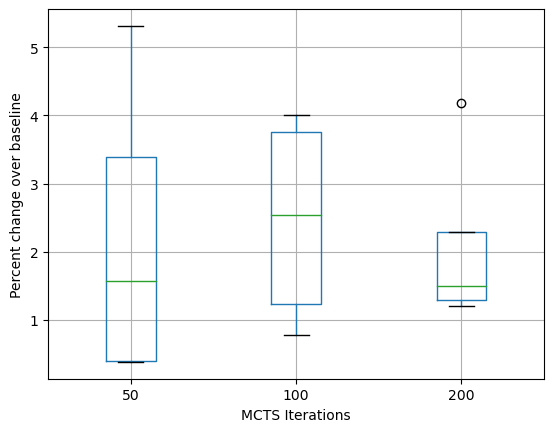

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
data = {50:[0.381700142,0.401851462,5.312641372,2.749183189],
        100:[0.780799722,1.385440774,3.676166873,4.005728864],
        200:[1.200561132,1.656848306,4.177730572,1.32815647],
        }
df = pd.DataFrame(data)
ax = df.boxplot()
ax.set_ylabel("Percent change over baseline")
ax.set_xlabel("MCTS Iterations")
fp = 'plots/iterations_all.eps'
plt.savefig(fp, format='eps')

# Breakdown takeover plot

In [128]:
bus_stats = []
# fp = 'IT_SEARCH/no_inject_20211215_no_break_BL.log'
fp = 'IT_SEARCH/no_inject_20211215_break_BL.log'
with open(fp) as file:
    for line in file:
        if 'on trip:' in line:
            data = line.rstrip()
            in_brackets = re.findall("\[(.*?)\]", data)
            out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
            log_text = out_brackets[2].strip()
            
            time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
            bus = log_text.split(" ")[1]
            trip = log_text.split(" ")[4]
            scheduled_time = log_text.split(" ")[7] + " " + log_text.split(" ")[8]
            scheduled_time = dt.datetime.strptime(scheduled_time, DATETIME_FORMAT)
            stop_id = log_text.split(" ")[12][:-1]
            got_on = log_text.split(" ")[13].split(":")[1][:-1]
            on = log_text.split(" ")[14].split(":")[1][:-1]
            offs = log_text.split(" ")[15].split(":")[1][:-1]
            remain = log_text.split(" ")[16].split(":")[1][:-1]
            load = log_text.split(" ")[17].split(":")[1]
            
            entry = {"actual_time":time,
                    "bus_id":bus,
                    "trip_id":trip,
                    "scheduled_time":scheduled_time,
                    "stop_id":stop_id,
                    "got_on_bus":got_on,
                    "waiting_to_board":on,
                    "offs":offs,
                    "left":remain,
                    "load":load}
            bus_stats.append(entry)
bus_stats = pd.DataFrame(bus_stats)
bus_stats['got_on_bus'] = bus_stats['got_on_bus'].astype('int')
bus_stats['waiting_to_board'] = bus_stats['waiting_to_board'].astype('int')
bus_stats['offs'] = bus_stats['offs'].astype('int')
bus_stats['left'] = bus_stats['left'].astype('int')
bus_stats['load'] = bus_stats['load'].astype('int')
bus_stats.query("bus_id == '1830'")

,actual_time,bus_id,trip_id,scheduled_time,stop_id,got_on_bus,waiting_to_board,offs,left,load
24,2021-12-15 08:15:00,1830,261584,2021-12-15 08:15:00,MCC4_18,1,1,0,0,1
34,2021-12-15 08:16:34,1830,261584,2021-12-15 08:16:34,UNI2AEF,0,0,1,0,0
43,2021-12-15 08:18:21,1830,261584,2021-12-15 08:18:21,WOON1SEN,1,1,0,0,1
54,2021-12-15 08:19:52,1830,261584,2021-12-15 08:19:52,WOO5SEN,1,2,0,1,2
58,2021-12-15 08:20:12,1830,261584,2021-12-15 08:20:12,5SRUSSN,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
1285,2021-12-15 09:56:42,1830,261586,2021-12-15 09:56:42,RIVDORNM,0,1,0,1,2
1292,2021-12-15 09:57:21,1830,261586,2021-12-15 09:57:21,RIVPIENN,0,0,2,0,0
1308,2021-12-15 09:58:40,1830,261586,2021-12-15 09:58:40,MCGGLEWN,2,2,0,0,2
1313,2021-12-15 09:59:05,1830,261586,2021-12-15 09:59:05,MCGHUFWN,0,0,2,0,0


In [129]:
bus_stats2 = []
fp = 'IT_SEARCH/no_inject_20211215_no_break_BL.log'
# fp = 'IT_SEARCH/no_inject_20211215_break_BL.log'
with open(fp) as file:
    for line in file:
        if 'on trip:' in line:
            data = line.rstrip()
            in_brackets = re.findall("\[(.*?)\]", data)
            out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
            log_text = out_brackets[2].strip()
            
            time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
            bus = log_text.split(" ")[1]
            trip = log_text.split(" ")[4]
            scheduled_time = log_text.split(" ")[7] + " " + log_text.split(" ")[8]
            scheduled_time = dt.datetime.strptime(scheduled_time, DATETIME_FORMAT)
            stop_id = log_text.split(" ")[12][:-1]
            got_on = log_text.split(" ")[13].split(":")[1][:-1]
            on = log_text.split(" ")[14].split(":")[1][:-1]
            offs = log_text.split(" ")[15].split(":")[1][:-1]
            remain = log_text.split(" ")[16].split(":")[1][:-1]
            load = log_text.split(" ")[17].split(":")[1]
            
            entry = {"actual_time":time,
                    "bus_id":bus,
                    "trip_id":trip,
                    "scheduled_time":scheduled_time,
                    "stop_id":stop_id,
                    "got_on_bus":got_on,
                    "waiting_to_board":on,
                    "offs":offs,
                    "left":remain,
                    "load":load}
            bus_stats2.append(entry)
bus_stats2 = pd.DataFrame(bus_stats2)
bus_stats2['got_on_bus'] = bus_stats2['got_on_bus'].astype('int')
bus_stats2['waiting_to_board'] = bus_stats2['waiting_to_board'].astype('int')
bus_stats2['offs'] = bus_stats2['offs'].astype('int')
bus_stats2['left'] = bus_stats2['left'].astype('int')
bus_stats2['load'] = bus_stats2['load'].astype('int')
bus_stats2.query("bus_id == '1830'")

,actual_time,bus_id,trip_id,scheduled_time,stop_id,got_on_bus,waiting_to_board,offs,left,load
24,2021-12-15 08:15:00,1830,261584,2021-12-15 08:15:00,MCC4_18,1,1,0,0,1
34,2021-12-15 08:16:34,1830,261584,2021-12-15 08:16:34,UNI2AEF,0,0,1,0,0
43,2021-12-15 08:18:21,1830,261584,2021-12-15 08:18:21,WOON1SEN,1,1,0,0,1
54,2021-12-15 08:19:52,1830,261584,2021-12-15 08:19:52,WOO5SEN,1,2,0,1,2
58,2021-12-15 08:20:12,1830,261584,2021-12-15 08:20:12,5SRUSSN,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
2428,2021-12-15 11:20:44,1830,261588,2021-12-15 11:20:44,MCGHUFWN,2,2,0,0,2
2437,2021-12-15 11:21:12,1830,261588,2021-12-15 11:21:12,MCGSCOWM,0,1,0,1,2
2452,2021-12-15 11:22:22,1830,261588,2021-12-15 11:22:22,MCGGALWN,0,1,0,1,2
2463,2021-12-15 11:23:10,1830,261588,2021-12-15 11:23:10,GALIVENN,0,1,0,1,2


/tmp/ipykernel_106018/2548104011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['load'] = tdf.got_on_bus.cumsum()
/tmp/ipykernel_106018/2548104011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['load'] = tdf.got_on_bus.cumsum()
/tmp/ipykernel_106018/2548104011.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([pandas_datetime.strftime("%H:%M:%S") for pandas_datetime in _df.index])
The PostScript backend does not support transparency; par

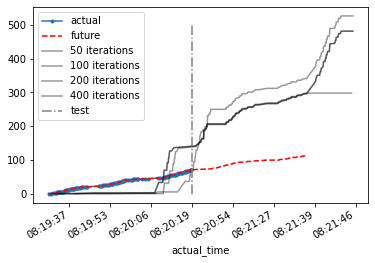

In [158]:
tdf = bus_stats.query("bus_id == '1830'")
tdf['load'] = tdf.got_on_bus.cumsum()
tdf = tdf.set_index('actual_time')
ax = tdf.load.plot(marker='o', markersize=3, label='actual')

tdf = bus_stats2.query("bus_id == '1830'")
tdf['load'] = tdf.got_on_bus.cumsum()
tdf = tdf.set_index('actual_time')
ax = tdf.load.plot(color='red', linestyle='--', label='future')

for IT in [50, 100, 200, 400]:
    _df = df[df['date'] == dt.date(2021, 12, 15)].query(f"bus_id == '42' and IT == {IT}")
    _df['load'] = _df.got_on_bus.cumsum()
    _df = _df.set_index('actual_time')
    _df.load.plot(ax=ax, color='black', alpha=0.4, label=f"{IT} iterations")

ax.vlines(x=dt.datetime(2021,12,15,10,0,0), ymin=0, ymax=500, color='grey', ls='-.', label='test')
ax.legend()
ax.set_xticklabels([pandas_datetime.strftime("%H:%M:%S") for pandas_datetime in _df.index])
fp = 'plots/breakdown.eps'
plt.savefig(fp, format='eps')
plt.show()

# Decision epoch times

In [193]:
df_arr = []
dates = ['20210507', '20210607', '20210825'] # 20210713
for date in dates:
    df = pd.read_csv(f"decision_epoch_times/{date}_decision_timer.log", delimiter=":", names=['a', 'b', 'c'])
    df[['decision_time', '_']] = df['c'].str.split('}',expand=True)
    df.reset_index(inplace=True, drop=True)
    # df = df.drop(['a', 'b'], axis=1)
    df['decision_time'] = df['decision_time'].astype('float')
    df['IT'] = 100
    df_arr.append(df[['decision_time', 'IT']])

df = pd.read_csv(f"decision_epoch_times/20210713_decision_timer.log", delimiter=":", names=['a', 'b', 'c'])
df = df[['c']].rename({'c':'decision_time'}, axis=1).reset_index(drop=True)
df['decision_time'] = df['decision_time'].astype('float')
df['IT'] = 100
df_arr.append(df)

df = pd.read_csv(f"decision_epoch_times/20210713_decision_timer_200.log", delimiter=":", names=['a', 'b', 'c'])
df = df[['c']].rename({'c':'decision_time'}, axis=1).reset_index(drop=True)
df['decision_time'] = df['decision_time'].astype('float')
df['IT'] = 200
df_arr.append(df)
df_arr = pd.concat(df_arr)

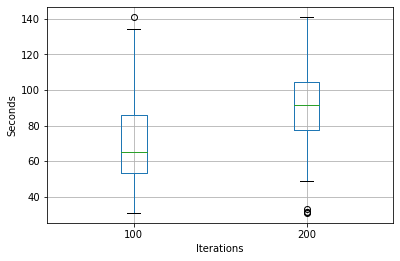

In [210]:
ax = df_arr.boxplot(by='IT')
plt.suptitle('') # that's what you're after
ax.set_title('')
ax.set_xlabel('Iterations')
ax.set_ylabel('Seconds')
fp = 'plots/decision_time.eps'
plt.savefig(fp, format='eps')